
Simulate forcing ACL pathway in the NP11 model.And observe what happens with XPK. 
* You can  make a graph with flux of PKETF_c (phosphoketolase (fructose 6-phosphate)) on y axis and ACL on x axis, if you do forcing simulations in few steps. You will obtain like a linear line. 
* FBA params: I suggest Glc max at 0.05 GR and another round for 0.3 GR. 
* And extract cofactor balances, and compare how it changes when ACL is forced to have a flux. Especially NADH.



In [1]:
import cobra
import pandas as pd
import os 
from os.path import join 
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling 
import numpy as np
# os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
# import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt


In [2]:
# NGAM min
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")
model1.objective =  'r_4041' #'r_4046' # NGAM
solution1 = model1.optimize() #'minimize'
all_fluxes = solution1.fluxes.to_frame(name='Flux')


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21


In [3]:
# model1.reactions.t_0081.summary()
 
# model1.metabolites.s_0373.summary()



In [5]:
glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 3.1] 
growth_rates =  [0.03070, 0.08340, 0.12751, 0.1817, 0.24744] # computed when model is optimized for biomass growth and glc uptake is constrained - original: #[0.030702, 0.083402, 0.127511, 0.18178, 0.247448]
 
all_fluxes_NGAM_min = pd.DataFrame(columns=['Glucose uptake', 'Growth rate', *all_fluxes.index], index=range(len(glucose_uptakes))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(glucose_uptakes)):
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")
    model.reactions.r_4041.bounds = growth_rates[i], growth_rates[i]
    model.reactions.r_1714.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.objective =  'r_4046' # NGAM
    solution = model.optimize('minimize') #
    all_fluxes_NGAM_min.loc[i] = solution.fluxes[['r_1714', 'r_4041', *all_fluxes.index]].values
    
all_fluxes_NGAM_min

In [5]:
# Exchange fluxes
exchange_fluxes_table = all_fluxes_NGAM_min[['r_1714', 'r_1992', 'r_1654','r_2060','r_2005', 'r_1672']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,D-glucose exchange,oxygen exchange,ammonium exchange,sulphate exchange,phosphate exchange,carbon dioxide exchange
0,-0.476,-1.488312,-0.126158,-0.00261,-0.006738,1.588705
1,-1.114,-2.968575,-0.342734,-0.00709,-0.018322,3.241298
2,-1.648,-4.2075,-0.524005,-0.010839,-0.028014,4.624467
3,-2.305,-5.735366,-0.746699,-0.015446,-0.039919,6.329537
4,-3.1,-7.576677,-1.016846,-0.021035,-0.054356,8.385815


In [6]:
intracellular_fluxes = all_fluxes_NGAM_min[['r_4046', 'r_1714', 'r_0466', 'r_1049', 'r_1048','r_1050', 't_0081', 'r_0450','r_0959','r_0961', 'y200003']] # t_0081 - has only one phosphoketolase, not XPK and FPK separately

# Change G6PDH2rp column name to oxpp 

for i in range(len(intracellular_fluxes.columns)):
    intracellular_fluxes = intracellular_fluxes.rename(columns = {intracellular_fluxes.columns[i]: getattr(model.reactions, intracellular_fluxes.columns[i]).name})

intracellular_fluxes = intracellular_fluxes.rename(columns = {'glucose 6-phosphate dehydrogenase': 'oxPPP', 'non-growth associated maintenance reaction': 'NGAM'})
intracellular_fluxes

,NGAM,D-glucose exchange,oxPPP,transketolase 1,transaldolase,transketolase 2,phosphoketolase,fructose-bisphosphate aldolase,pyruvate decarboxylase,pyruvate dehydrogenase,ATP-citrate lyase
0,3.3928,-0.476,0.180662,0.041977,-0.232571,0.03678,0.051303,0.0,0.060651,0.464389,0.0
1,3.3928,-1.114,0.489495,0.113615,0.0,0.099499,0.139334,0.45357,0.164802,0.901208,0.0
2,3.3928,-1.648,0.747269,0.172394,0.172394,0.150812,0.215842,0.81047,0.249149,1.266553,0.0
3,3.3928,-2.305,1.064848,0.152573,0.152573,0.121819,0.586833,0.925358,0.075774,1.811153,0.0
4,3.3928,-3.1,1.453313,0.337857,0.337857,0.295976,0.412102,1.478156,0.490239,2.264842,0.0


Text(0, 0.5, 'Flux $(g/gDW/h)$')

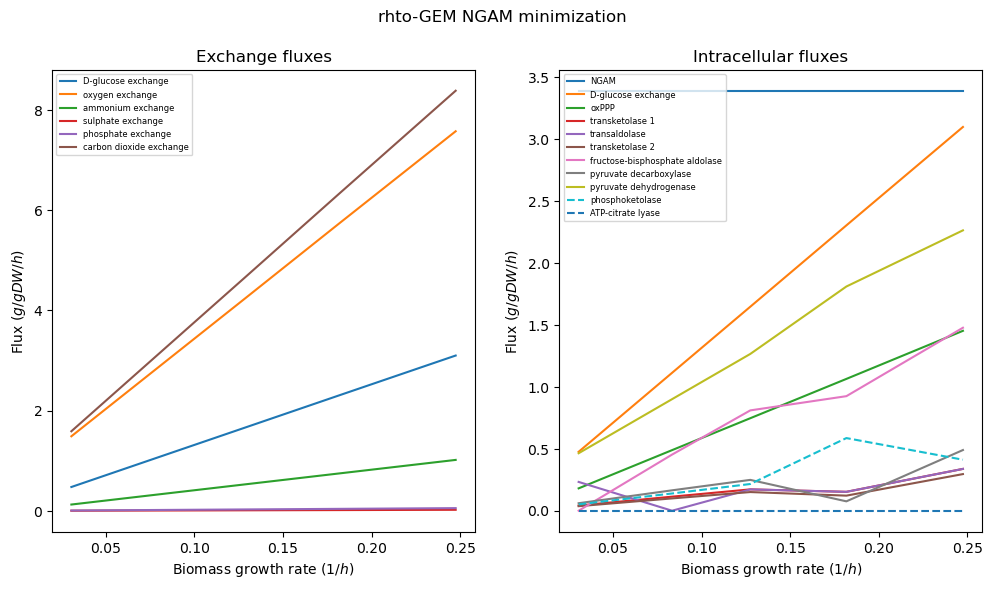

In [7]:
# Plot exchange and intracellular fluxes
fig, ax = plt.subplots(1, 2, figsize=(12,6)) #, 
fig.suptitle('rhto-GEM NGAM minimization')

# Sample data

x1 = all_fluxes_NGAM_min['r_4041']
y1 = np.abs(exchange_fluxes_table)

ax[0].plot(x1, y1, '-', label= y1.columns) #
ax[0].legend(fontsize=6, loc='upper left')
ax[0].set_title("Exchange fluxes") #fluxes biomass maximization
ax[0].set_xlabel('Biomass growth rate $(1/h)$')
ax[0].set_ylabel('Flux $(g/gDW/h)$')

x2 = all_fluxes_NGAM_min['r_4041']
y2 = np.abs(intracellular_fluxes.drop(columns = ['phosphoketolase','ATP-citrate lyase']))
y3 = np.abs(intracellular_fluxes[['phosphoketolase','ATP-citrate lyase']])

ax[1].plot(x2, y2, '-', label= y2.columns) #
ax[1].plot(x2, y3, '--', label= y3.columns) # ACL and phosphoketolase

ax[1].legend(fontsize=6, loc='upper left')
ax[1].set_title("Intracellular fluxes")
ax[1].set_xlabel('Biomass growth rate $(1/h)$')
ax[1].set_ylabel('Flux $(g/gDW/h)$')

In [8]:
# # Get all fluxes to excel

# with pd.ExcelWriter(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\NP11_all_fluxes_NGAM_min.xlsx') as excel_writer:
#     all_fluxes_NGAM_min.to_excel(excel_writer, sheet_name='Growth rates 0.05-0.3', index=True)

# #  Get all flux values separately for dif growth rates, make them to a csv file
# for i in range(len(glucose_uptakes)):
# all_fluxes_NGAM_min.loc[0].to_csv(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\NP11_fluxes_NGAM_min_GR_{growth_rates[0]}.csv' , index=True)

COFACTOR BALANCES, when optimized for NGAM min

In [2]:
# Cofactor lists
nadphs = ['s_1212', 's_1213', 's_1214', 's_1215', 's_2799','s_2952']
nadhs = ['s_1203', 's_1204', 's_1205', 's_1206', 's_1206', 's_3753']
atps = ['s_0434', 's_0435', 's_0437', 's_3881', 's_0438', 's_0439', 's_3359', 's_2840', 's_2831', 's_2856', 's_3341'] 

# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 3.1] 
    growth_rates =  [0.03070, 0.08340, 0.12751, 0.1817, 0.24744]
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.reactions.r_4041.bounds = growth_rates[i], growth_rates[i]
    model.reactions.r_1714.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.objective =  'r_4046' # NGAM
    solution = model.optimize('minimize') #

    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title):
    threshold = 0.05# threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.objective = 'r_1714'
    solution = model.optimize()
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), getattr(model.reactions, reaction).name, ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other producing', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other consuming', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
    fig = plt.figure()
        
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    # plt.title(title)

    return pie_chart, fig


In [3]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 4)
nadph_fluxes_highest_GR

# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 4)
nadh_fluxes_highest_GR

# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get atp fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 4)
atp_fluxes_highest_GR

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21
SUM produced: 0.39327447721232145, SUM consumed: -0.39327466141228357
SUM produced: 3.169769140243988, SUM consumed: -3.1697691402439987
SUM produced: 3.2718254595644907, SUM consumed: -3.271825449331307
SUM produced: 17.532342440475418, SUM consumed: -17.532342440475663
SUM produced: 8.816300107362352, SUM consumed: -8.81630008689582
SUM produced: 45.62984740614632, SUM consumed: -45.62984740614651


,flux,reaction,percent
r_0226,36.533509,r_0226,0.800649
r_0892,3.648946,r_0892,0.079968
r_0962,3.328530,r_0962,0.072946
r_1022,1.915002,r_1022,0.041968
r_0447,0.200891,r_0447,0.004403
...,...,...,...
r_0886,-1.142020,r_0886,0.025028
r_0148,-1.342382,r_0148,0.029419
r_0534,-3.100000,r_0534,0.067938
r_4046,-3.396000,r_4046,0.074425


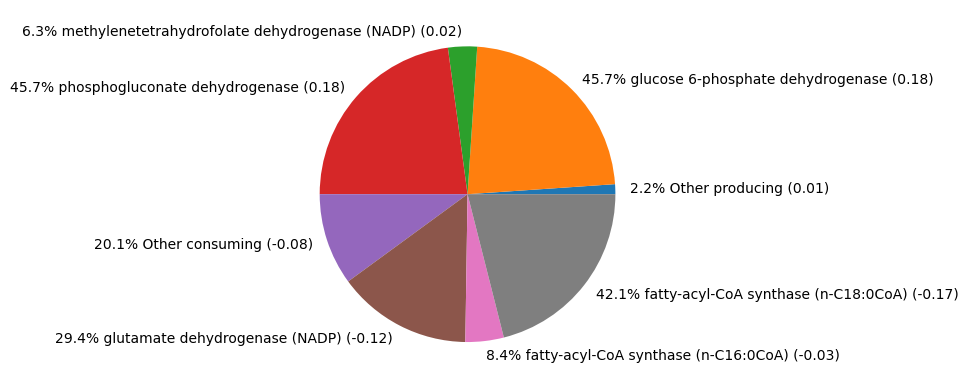

In [6]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'rhto-GEM NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadph_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title)
producing_nadph_fluxes_lowest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\rhtoGEM_nm_NADPH.png")


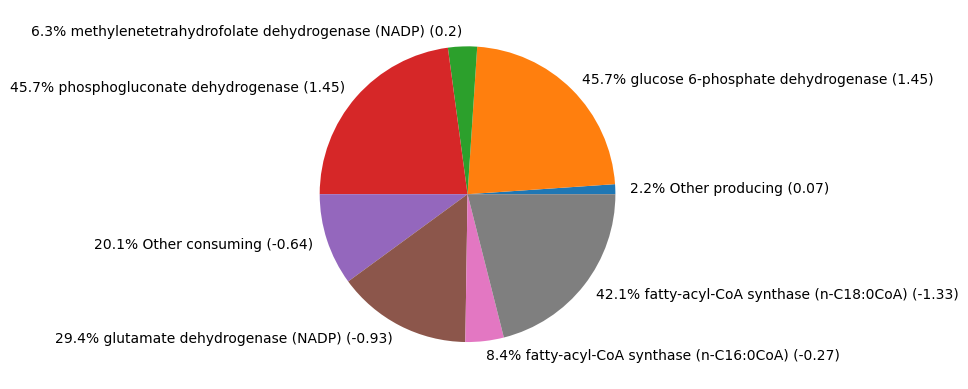

In [7]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'rhto-GEM NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadph_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title)
producing_nadph_fluxes_highest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\rhtoGEM_nm_NADPH_max.png")



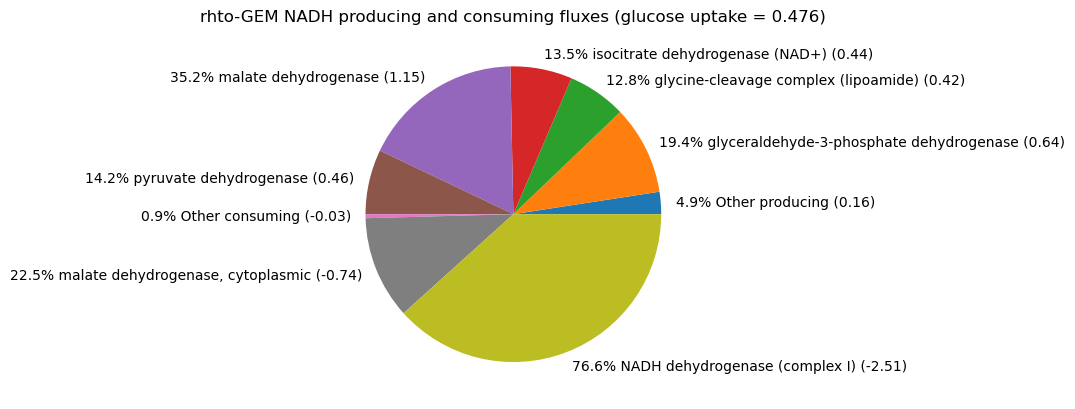

([<matplotlib.patches.Wedge at 0x15ba3c39b80>,
 [Text(1.0967903575767668, 0.0839697060053711, '4.9% Other producing (0.16)'),
  Text(0.9866723657336123, 0.4862896695362108, '19.4% glyceraldehyde-3-phosphate dehydrogenase (0.64)'),
  Text(0.6265136811975023, 0.9041463417347629, '12.8% glycine-cleavage complex (lipoamide) (0.42)'),
  Text(0.20996270999535654, 1.0797757454265242, '13.5% isocitrate dehydrogenase (NAD+) (0.44)'),
  Text(-0.596429136320873, 0.924268513662311, '35.2% malate dehydrogenase (1.15)'),
  Text(-1.0729179987466235, 0.24258394004043338, '14.2% pyruvate dehydrogenase (0.46)'),
  Text(-1.0998984232853786, -0.01494852682836227, '0.9% Other consuming (-0.03)'),
  Text(-1.0213206130096353, -0.40853911127531334, '22.5% malate dehydrogenase, cytoplasmic (-0.74)'),
  Text(0.3946220238866686, -1.0267781933132345, '76.6% NADH dehydrogenase (complex I) (-2.51)')])

In [13]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'rhto-GEM NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadh_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

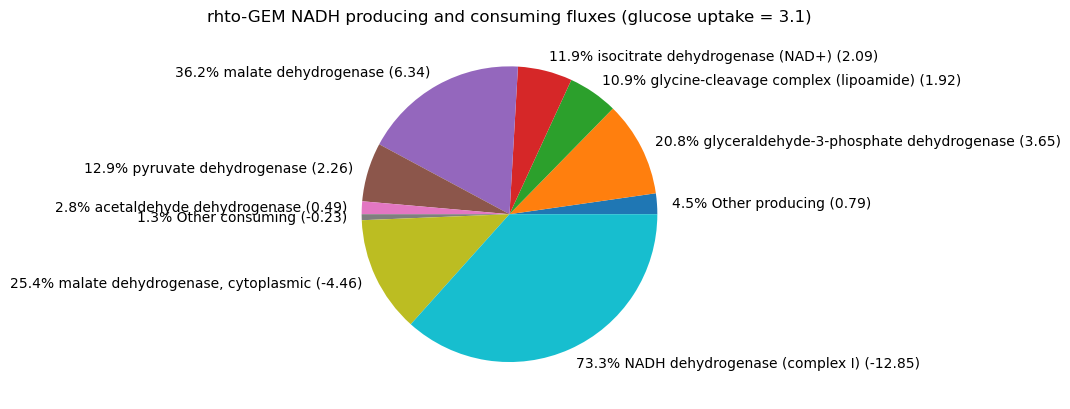

([<matplotlib.patches.Wedge at 0x15ba73c9fd0>,
 [Text(1.0972192258288087, 0.07816630010196045, '4.5% Other producing (0.79)'),
  Text(0.9811408082540121, 0.49735572217344004, '20.8% glyceraldehyde-3-phosphate dehydrogenase (3.65)'),
  Text(0.6239486907175578, 0.905918335917673, '10.9% glycine-cleavage complex (lipoamide) (1.92)'),
  Text(0.2662930533639476, 1.0672806611806034, '11.9% isocitrate dehydrogenase (NAD+) (2.09)'),
  Text(-0.5373586316466604, 0.9598154515295265, '36.2% malate dehydrogenase (6.34)'),
  Text(-1.0540381169730224, 0.3146484513992804, '12.9% pyruvate dehydrogenase (2.26)'),
  Text(-1.098944544460993, 0.04817559755125521, '2.8% acetaldehyde dehydrogenase (0.49)'),
  Text(-1.0997701984055985, -0.022483565084530952, '1.3% Other consuming (-0.23)'),
  Text(-0.995056670878083, -0.46889468086237296, '25.4% malate dehydrogenase, cytoplasmic (-4.46)'),
  Text(0.44845821913720774, -1.0044327880392416, '73.3% NADH dehydrogenase (complex I) (-12.85)')])

In [14]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'rhto-GEM NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadh_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart



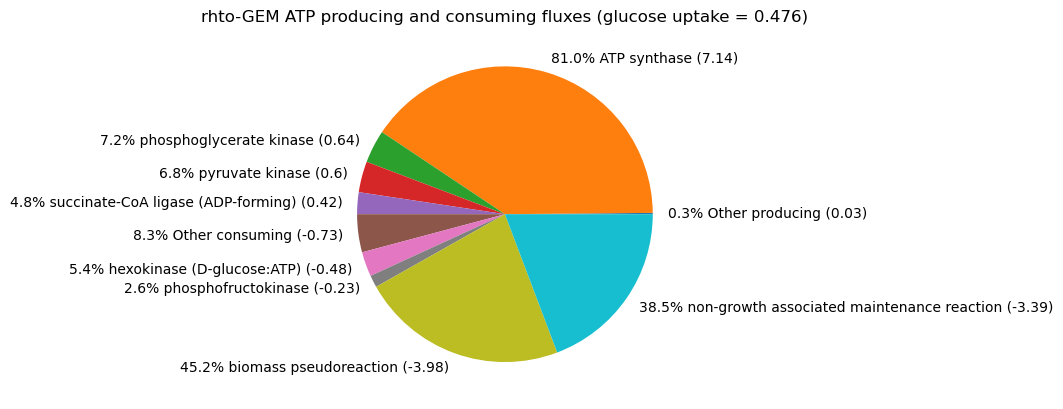

([<matplotlib.patches.Wedge at 0x15ba470c620>,
 [Text(1.0999888305811112, 0.004957075428071777, '0.3% Other producing (0.03)'),
  Text(0.31428963801538673, 1.0541451624117797, '81.0% ATP synthase (7.14)'),
  Text(-0.978071603549098, 0.5033646176787722, '7.2% phosphoglycerate kinase (0.64)'),
  Text(-1.0641705423128653, 0.27846194869953417, '6.8% pyruvate kinase (0.6)'),
  Text(-1.0969163486569702, 0.08230749691893313, '4.8% succinate-CoA ligase (ADP-forming) (0.42)'),
  Text(-1.0906612685691348, -0.143031455432593, '8.3% Other consuming (-0.73)'),
  Text(-1.0349580411319557, -0.37264172216259617, '5.4% hexokinase (D-glucose:ATP) (-0.48)'),
  Text(-0.9797571508595455, -0.5000759195758041, '2.6% phosphofructokinase (-0.23)'),
  Text(-0.37501347083335923, -1.0341010089413498, '45.2% biomass pseudoreaction (-3.98)'),
  Text(0.9049840815892691, -0.6253029762203496, '38.5% non-growth associated maintenance reaction (-3.39)')])

In [15]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'rhto-GEM ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_atp_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

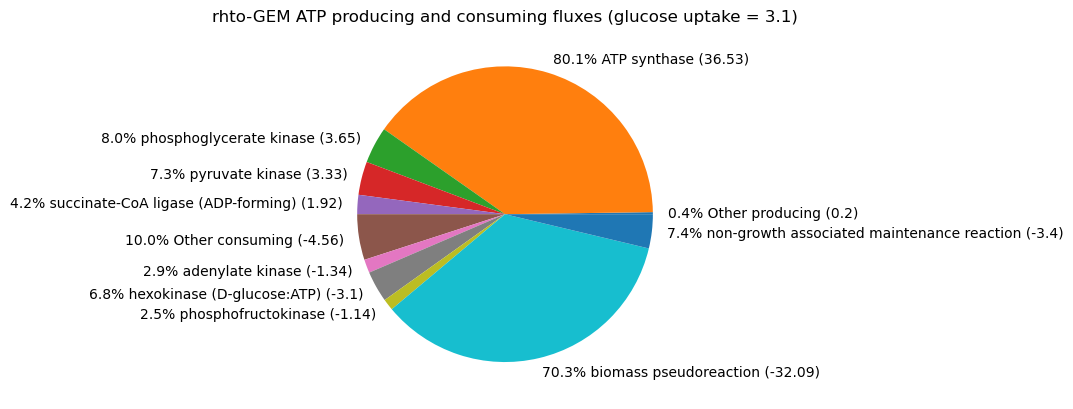

([<matplotlib.patches.Wedge at 0x15bab1ebaa0>,
 [Text(1.0999729126046425, 0.007719555431473744, '0.4% Other producing (0.2)'),
  Text(0.3241299065454209, 1.0511611692232818, '80.1% ATP synthase (36.53)'),
  Text(-0.9723060550774734, 0.514413195067624, '8.0% phosphoglycerate kinase (3.65)'),
  Text(-1.066768293438815, 0.2683382345355177, '7.3% pyruvate kinase (3.33)'),
  Text(-1.0976106387268885, 0.07246299575336405, '4.2% succinate-CoA ligase (ADP-forming) (1.92)'),
  Text(-1.0864956442773839, -0.17183484793915607, '10.0% Other consuming (-4.56)'),
  Text(-1.0295164424587762, -0.3874221143752968, '2.9% adenylate kinase (-1.34)'),
  Text(-0.958484261610527, -0.5397294880261065, '6.8% hexokinase (D-glucose:ATP) (-3.1)'),
  Text(-0.8697454711744865, -0.6734558748511075, '2.5% phosphofructokinase (-1.14)'),
  Text(0.2531215875082207, -1.0704809488904128, '70.3% biomass pseudoreaction (-32.09)'),
  Text(1.0924917059614674, -0.12830382849082447, '7.4% non-growth associated maintenance reacti

In [16]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'rhto-GEM ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_atp_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [17]:
# import pickle

# with open("../cofactor_comparison/NP11_NGAM_cofactors.pk", "wb") as f:
#     pickle.dump([nadph_fluxes_lowest_GR, nadph_fluxes_highest_GR, nadh_fluxes_lowest_GR, nadh_fluxes_highest_GR, atp_fluxes_lowest_GR, atp_fluxes_highest_GR], f)


In [18]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\NP11_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[0]}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[5]}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[0]}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[5]}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[0]}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[5]}', index=False)
